In [1]:
import numpy as np

import glob
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset

import advertorch
from advertorch.attacks import GradientSignAttack
from advertorch.attacks import LinfPGDAttack
from advertorch.attacks import CarliniWagnerL2Attack

# Need the model for which AE is generated here
from Resnet_adaptation import new_cnn_model

In [2]:
# RANDOMIZE
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# get scalers
training_set = np.load('./data/train.npz')

mean = round(training_set['x'][...,0].mean(), 2)
std = round(training_set['x'][...,0].std(), 2)

print("Mean ={}, Std = {}".format(mean, std))

Mean =4090.28, Std = 2164.09


In [5]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [6]:
# load all trained linear models
# load all pretrained models
paths = glob.glob('./lr/best_models/*.pt')
print(len(paths))

trained_models = []
for i in paths:
    trained_models.append(torch.load(i))
    
print(len(trained_models))

150
150


In [7]:
# load adversarial data and reshape

fgsm_flow = np.load('./lr/adv_fgsm.npy', allow_pickle = True)
print("Shape = {}, Max = {}".format(fgsm_flow.shape, np.max(fgsm_flow)))

bim_flow = np.load('./lr/adv_bim.npy', allow_pickle = True)
print("Shape = {}, Max = {}".format(bim_flow.shape, np.max(bim_flow)))

fgsm_flow = fgsm_flow*std + mean
print("Shape = {}, Max = {}".format(fgsm_flow.shape, np.max(fgsm_flow)))

bim_flow = bim_flow*std + mean
print("Shape = {}, Max = {}".format(bim_flow.shape, np.max(bim_flow)))

# reshape to 

n_nodes= 150
fgsm_flow_new = []

for i in range(n_nodes):
    samples_collect = []
    for j in range(len(fgsm_flow)):
        for k in range(n_nodes):
            if k==i:
                samples_collect.append(fgsm_flow[j,:,k])
    fgsm_flow_new.append(samples_collect)
    
fgsm_flow_new = np.array(fgsm_flow_new)
print(fgsm_flow_new.shape)

n_nodes= 150
bim_flow_new = []

for i in range(n_nodes):
    samples_collect = []
    for j in range(len(bim_flow)):
        for k in range(n_nodes):
            if k==i:
                samples_collect.append(bim_flow[j,:,k])
    bim_flow_new.append(samples_collect)
    
bim_flow_new = np.array(bim_flow_new)
print(bim_flow_new.shape)

Shape = (2616, 12, 150), Max = 3.490483283996582
Shape = (2616, 12, 150), Max = 3.490483283996582
Shape = (2616, 12, 150), Max = 11644.0
Shape = (2616, 12, 150), Max = 11644.0
(150, 2616, 12)
(150, 2616, 12)


In [8]:
class TR_dataset_no_targets(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, key):
        input_seq = self.data_list[key]
        return input_seq

In [9]:
# make dataloaders
BATCH_SIZE = 1

fgsm_data_loaders =[]
bim_data_loaders =[]

for i in range(len(trained_models)):
    fgsm_set = TR_dataset_no_targets(fgsm_flow_new[i])
    
    fgsm_dataloader = torch.utils.data.DataLoader(dataset=fgsm_set,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=None,
                                               shuffle=False)
    fgsm_data_loaders.append(fgsm_dataloader)
    
    bim_set = TR_dataset_no_targets(bim_flow_new[i])
    
    bim_dataloader = torch.utils.data.DataLoader(dataset=bim_set,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=None,
                                               shuffle=False)
    
    
    bim_data_loaders.append(bim_dataloader)

In [10]:
# make inference
fgsm_outputs = []

for i in range(len(trained_models)):
    
    new_model = trained_models[i].eval()
    new_model.to(device)
    
    output_model = []
    
    with torch.no_grad():
        
        # enumerate the iterator correponding to the model
        for bi, data in enumerate(fgsm_data_loaders[i]):
            
            data_batch = data.float().to(device)
            
            #print(data_batch.shape)
            
            output_batch = new_model(data_batch)
            
            output_batch_numpy = output_batch.cpu().detach().numpy()
            
            #print(output_batch_numpy.shape)
            
            output_model.append(np.squeeze(output_batch_numpy))
            
    fgsm_outputs.append(output_model)
    
fgsm_outputs = np.array(fgsm_outputs)
print(fgsm_outputs.shape)
np.save('./lr/fgsm_linear_model_output.npy', fgsm_outputs)

(150, 2616, 12)


In [11]:
# make inference
bim_outputs = []

for i in range(len(trained_models)):
    
    new_model = trained_models[i].eval()
    new_model.to(device)
    
    output_model = []
    
    with torch.no_grad():
        
        # enumerate the iterator correponding to the model
        for bi, data in enumerate(bim_data_loaders[i]):
            
            data_batch = data.float().to(device)
            
            #print(data_batch.shape)
            
            output_batch = new_model(data_batch)
            
            output_batch_numpy = output_batch.cpu().detach().numpy()
            
            #print(output_batch_numpy.shape)
            
            output_model.append(np.squeeze(output_batch_numpy))
            
    bim_outputs.append(output_model)
    
bim_outputs = np.array(bim_outputs)
print(bim_outputs.shape)
np.save('./lr/bim_linear_model_output.npy', bim_outputs)

(150, 2616, 12)


In [12]:
fgsm_preds = np.load('./lr/fgsm_linear_model_output.npy', allow_pickle = True)
bim_preds = np.load('./lr/bim_linear_model_output.npy', allow_pickle = True)

print(fgsm_preds.shape, bim_preds.shape)

# convert back the shape

fgsm_preds_new=[]

num_samples = fgsm_preds.shape[1]

for i in range(num_samples):
    sample_collect=[]
    for j in range(len(fgsm_preds)):
        for k in range(num_samples):
            if i==k:
                selected = fgsm_preds[j,i,:]
                sample_collect.append(selected)
                
    sample_collect = np.array(sample_collect).T.reshape((12,150), order='C')
      
    fgsm_preds_new.append(sample_collect)
    
fgsm_preds_new = np.array(fgsm_preds_new)
print(fgsm_preds_new.shape)

bim_preds_new=[]

num_samples = bim_preds.shape[1]

for i in range(num_samples):
    sample_collect=[]
    for j in range(len(bim_preds)):
        for k in range(num_samples):
            if i==k:
                selected = bim_preds[j,i,:]
                sample_collect.append(selected)
                
    sample_collect = np.array(sample_collect).T.reshape((12,150), order='C')
      
    bim_preds_new.append(sample_collect)
    
bim_preds_new = np.array(bim_preds_new)
print(bim_preds_new.shape)

(150, 2616, 12) (150, 2616, 12)
(2616, 12, 150)
(2616, 12, 150)


In [30]:
print(fgsm_preds[140][2000][5])
print(fgsm_preds_new[2000][5][140])

5787.3
5787.3


In [13]:
print(np.max(fgsm_preds_new))
print(np.max(bim_preds_new))

13803.234
13722.801


In [14]:
# load gts
gts  = np.squeeze(np.load('./data/test.npz')['y']) # No need to denormalize
print("Shape = {}, max = {}".format(gts.shape, np.max(gts)))

Shape = (2616, 12, 150), max = 11644.0


In [15]:
def get_metrics(pred, truth):
    
    # assert both have same lengths
    num_signals = len(pred)
    #print(num_signals)
    
    number_of_nodes = 150
    time_steps = 12

    rmse_collect = []
    rmse = 0.0
    
    for i in range(num_signals):
        rmse_signal = np.sum(np.square(pred[i]- truth[i]))
        
        # save this to true rmse first
        rmse+= rmse_signal
        
        # arrange to collect
        rmse_signal = np.sqrt(rmse_signal/(time_steps*number_of_nodes))
        
        # collect it
        rmse_collect.append(round(rmse_signal,2))
        

    rmse = np.sqrt(rmse/(num_signals*time_steps*number_of_nodes))
    #print(rmse)
    rmse_collect = np.array(rmse_collect)
    
    return rmse, rmse_collect

In [16]:
rmse_fgsm, rmse_fgsm_collect = get_metrics(fgsm_preds_new, gts)
rmse_bim, rmse_bim_collect = get_metrics(bim_preds_new, gts)

In [17]:
print("FGSM:", rmse_fgsm)
print("BIM:", rmse_bim)

FGSM: 1916.8371010578492
BIM: 1891.2136722638445


In [18]:
# common metric
# define a common metric
def measure_l2(one, two):
    # Both will be 150*12 network wide snapshots
    one = np.squeeze(np.array(one))
    two = np.squeeze(np.array(two))
    l2 = np.sum(np.square(one-two))
    return l2

def notation(number):
    str_num = str(number)
    splits = str_num.split('.')
    leng = int(len(splits[0]))-1
    divisor = 1
    for i in range(leng):
        divisor = divisor*10
    changed_num = round((number/divisor),2)
    return changed_num, leng

In [19]:
originals = np.squeeze(np.load('./data/test.npz')['x'])
print(np.max(originals), originals.shape)

11644.0 (2616, 12, 150)


In [20]:
# change in signal
fgsm_sig_change_collect = []
for i in range(len(originals)):
    sig_change = measure_l2(originals[i], fgsm_flow[i])
    fgsm_sig_change_collect.append(sig_change)
fgsm_sig_change_collect = np.array(fgsm_sig_change_collect)
print(f'Signal: shape = {fgsm_sig_change_collect.shape}, max = {np.max(fgsm_sig_change_collect)}' )

fgsm_mean = np.mean(fgsm_sig_change_collect)
num_fgsm, exp_fgsm = notation(fgsm_mean)
print("FGSM: Mean = {}, a.k.a {}E{}".format(fgsm_mean,num_fgsm, exp_fgsm) )

Signal: shape = (2616,), max = 337196714.116767
FGSM: Mean = 335271182.3350971, a.k.a 3.35E8


In [21]:
# change in signal
bim_sig_change_collect = []
for i in range(len(originals)):
    sig_change = measure_l2(originals[i], bim_flow[i])
    bim_sig_change_collect.append(sig_change)
bim_sig_change_collect = np.array(bim_sig_change_collect)
print(f'Signal: shape = {bim_sig_change_collect.shape}, max = {np.max(bim_sig_change_collect)}' )

bim_mean = np.mean(bim_sig_change_collect)
num_bim, exp_bim = notation(bim_mean)
print("FGSM: Mean = {}, a.k.a {}E{}".format(bim_mean,num_bim, exp_bim) )

Signal: shape = (2616,), max = 157386022.70512205
FGSM: Mean = 145078424.27213487, a.k.a 1.45E8


In [22]:
# preds on originals
# need shape change?
outputs_lr = np.load('./lr/linear_model_output.npy', allow_pickle = True) 
print("Shape = {}, max = {}, mean = {}".format(outputs_lr.shape, np.max(outputs_lr), np.mean(outputs_lr)))

# output in the same shape as gts
outputs_lr_new=[]
num_samples = outputs_lr.shape[1]

for i in range(num_samples):
    sample_collect=[]
    for j in range(len(outputs_lr)):
        for k in range(num_samples):
            if i==k:
                selected = outputs_lr[j,i,:]
                sample_collect.append(selected)
                
    sample_collect = np.array(sample_collect).T.reshape((12,150), order='C')
    #print(sample_collect.shape)        
        
    outputs_lr_new.append(sample_collect)
    
outputs_lr_new = np.array(outputs_lr_new)
print(outputs_lr_new.shape)


Shape = (150, 2616, 12), max = 13225.5400390625, mean = 4160.63134765625
(2616, 12, 150)


In [29]:
print(outputs_lr[140][2000][5])
print(outputs_lr_new[2000][5][140])

5714.2715
5714.2715


In [27]:
print(fgsm_preds_new.shape)
print(bim_preds_new.shape)

print(np.max(fgsm_preds_new))
print(np.max(bim_preds_new))

print(np.max(outputs_lr_new))

(2616, 12, 150)
(2616, 12, 150)
13803.234
13722.801
13225.54


In [23]:
fgsm_preds_change_collect = []

for i in range(len(outputs_lr_new)):
    
    pred_change = measure_l2(outputs_lr_new[i], fgsm_preds_new[i])
    
    fgsm_preds_change_collect.append(pred_change)
    
fgsm_preds_change_collect = np.array(fgsm_preds_change_collect)

print(f'Signal: shape = {fgsm_preds_change_collect.shape}, max = {np.max(fgsm_preds_change_collect)}' )

preds_fgsm_mean = np.mean(fgsm_preds_change_collect)

p_num_fgsm, p_exp_fgsm = notation(preds_fgsm_mean)

print("preds FGSM: Mean = {}, a.k.a {}E{}".format(preds_fgsm_mean,p_num_fgsm, p_exp_fgsm) )

Signal: shape = (2616,), max = 379811968.0
preds FGSM: Mean = 315897184.0, a.k.a 3.16E8


In [24]:
# preds on adversarials
bim_preds_change_collect = []

for i in range(len(outputs_lr_new)):
    
    pred_change = measure_l2(outputs_lr_new[i], bim_preds_new[i])
    
    bim_preds_change_collect.append(pred_change)
    
bim_preds_change_collect = np.array(bim_preds_change_collect)

print(f'Signal: shape = {bim_preds_change_collect.shape}, max = {np.max(bim_preds_change_collect)}' )

preds_bim_mean = np.mean(bim_preds_change_collect)

p_num_bim, p_exp_bim = notation(preds_bim_mean)

print("preds FGSM: Mean = {}, a.k.a {}E{}".format(preds_bim_mean,p_num_bim, p_exp_bim) )

Signal: shape = (2616,), max = 171424144.0
preds FGSM: Mean = 137952032.0, a.k.a 1.38E8


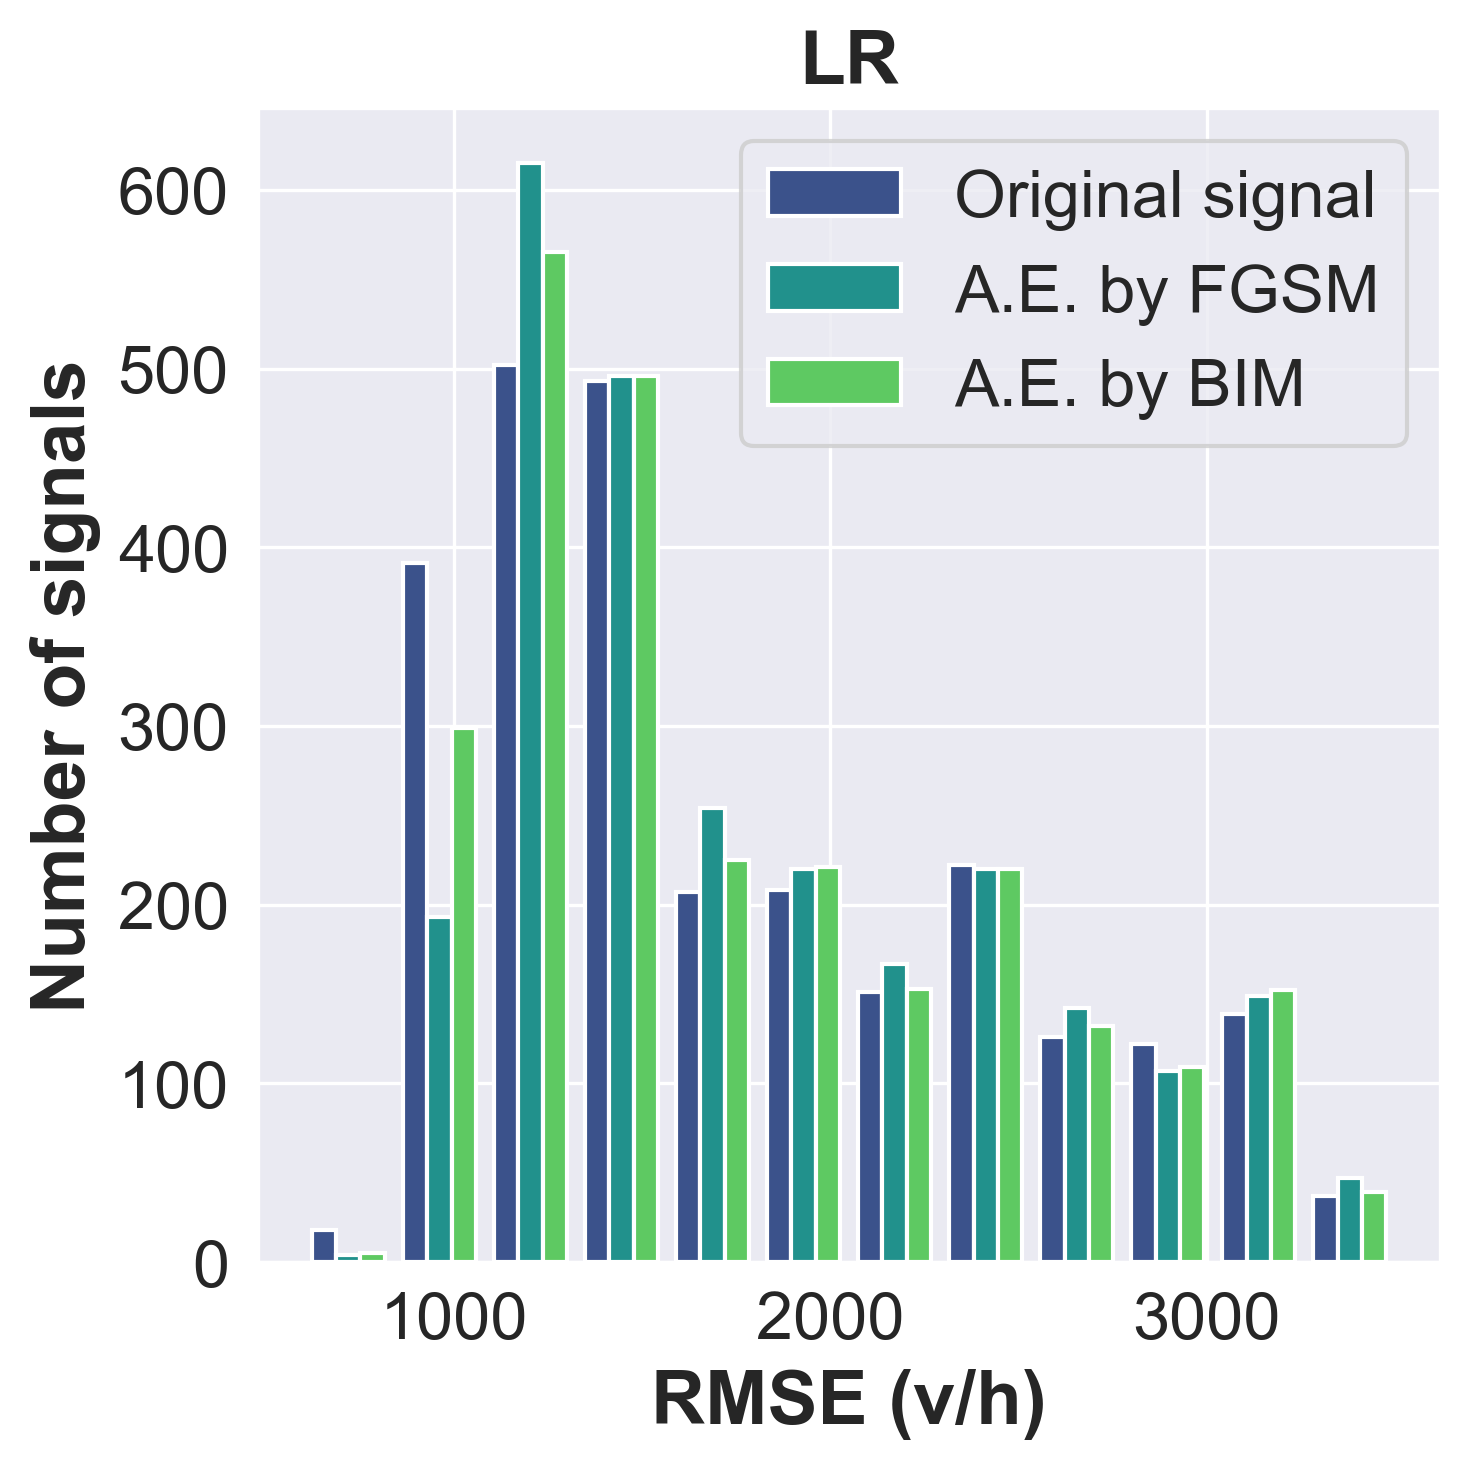

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette(palette='magma', n_colors=3)
sns.set_style("darkgrid")

# Load inputs
orig_dstr = np.load('./lr/original_dstr.npy', allow_pickle = True)
fgsm_dstr = rmse_fgsm_collect
bim_dstr = rmse_bim_collect

dstr_data = np.array([bim_dstr, fgsm_dstr, orig_dstr])
df = pd.DataFrame({'bim': dstr_data[2,:], 'fgsm': dstr_data[1,:], 'orig': dstr_data[0,:]})
df.shape


fs = 18

plt.rc('xtick', labelsize=fs-2) 
plt.rc('ytick', labelsize=fs-2) 

sns.set_palette(palette='viridis', n_colors=3)

n_bins = 12
x = df.values

fig, axes = plt.subplots(figsize=(5,5),dpi=300)
colors = df.columns
axes.hist(x, n_bins, density=False, histtype='bar', range=(600,3500), label=colors)

axes.set_title("LR", fontweight='bold',fontsize=fs)
labels =["Original signal","A.E. by FGSM","A.E. by BIM"]
axes.legend(labels, fontsize=fs-2)
axes.set_xlabel('RMSE (v/h)', fontweight='bold', fontsize=fs)
axes.set_ylabel('Number of signals', fontweight='bold', fontsize=fs);
fig.tight_layout()